In [1]:
import torch
import numpy as np
import cvxpy as cp
import cvxpylayers
from cvxpylayers.torch import CvxpyLayer
from algorithms import fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from latexify import latexify
cp.__version__, cvxpylayers.__version__

('1.1.0a4', '0.1.3')

In [2]:
# Define convex optimization model
m = 10

y = cp.Variable(m)
units = cp.Variable(m)
t = cp.Variable(m)
alpha = cp.Parameter(m, nonneg=True)
inverse_p = cp.Parameter(m, nonneg=True)
B = cp.Parameter(nonneg=True)

objective = cp.sum(t)
constraints = [cp.sum(y) == B, y >= 0,
               -cp.exp(-cp.multiply(alpha, units)) >= cp.multiply(alpha, t),
               units == cp.multiply(y, inverse_p)]
prob = cp.Problem(cp.Maximize(objective), constraints)
layer = CvxpyLayer(prob, [B, inverse_p, alpha], [y])

In [3]:
# Get data
def get_data(N, m, alpha):
    P = torch.rand(N, m)
    B = torch.rand(N) * 10
    Y = layer(B, 1 / P, alpha)[0]
    Y = Y * (torch.rand_like(Y) + .5)
    Y = Y * B[:,None] / Y.sum(1)[:,None]
    return torch.cat([B.unsqueeze(1), P], axis=1), Y

torch.manual_seed(0)
alpha_true = torch.rand(m)
X, Y = get_data(100, m, alpha_true)
Xval, Yval = get_data(50, m, alpha_true)
Y[:3]

tensor([[ 2.9211e-01,  4.5316e-01,  9.4326e-01,  1.9860e-01,  7.3760e-01,
          3.1330e-01,  1.3644e+00,  4.8556e-01,  5.5352e-01,  5.6666e-01],
        [ 1.3083e-01, -1.1127e-08,  3.7344e-01,  1.8442e-08,  2.2681e-01,
          1.1067e-08,  1.0708e-08,  1.7964e-08, -1.8988e-08,  3.0709e-01],
        [ 3.2713e-01,  6.7104e-01,  6.5384e-01,  5.6062e-01,  8.3935e-01,
          3.0430e-01,  2.0327e+00,  9.8297e-01,  4.8012e-01,  2.0594e+00]])

In [4]:
loss_fn = torch.nn.MSELoss()

In [5]:
torch.manual_seed(1)
alpha = torch.rand(m)
alpha.requires_grad_(True)
def loss(X, Y, alpha):
    Yhat = layer(X[:,0], 1. / X[:,1:], alpha)[0]
    return loss_fn(Y, Yhat)

def callback():
    alpha.data = torch.max(alpha.data, torch.zeros_like(alpha.data))

print(loss(X, Y, alpha_true), loss(Xval, Yval, alpha_true))
print(loss(X, Y, alpha), loss(Xval, Yval, alpha))

val_losses, train_losses = fit(lambda X, Y: loss(X, Y, alpha), [alpha], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr":1e-2},
                               batch_size=4, epochs=25, verbose=True, callback=callback)

tensor(0.0321) tensor(0.0282)
tensor(0.8471, grad_fn=<MeanBackward0>) tensor(0.7306, grad_fn=<MeanBackward0>)
001 | 0.73061
batch 001 / 025 | 0.95666
batch 002 / 025 | 1.00477
batch 003 / 025 | 0.94091
batch 004 / 025 | 0.84717
batch 005 / 025 | 0.89175
batch 006 / 025 | 0.85781
batch 007 / 025 | 0.78630
batch 008 / 025 | 0.71243
batch 009 / 025 | 0.75978
batch 010 / 025 | 0.71935
batch 011 / 025 | 0.68150
batch 012 / 025 | 0.64122
batch 013 / 025 | 0.62107
batch 014 / 025 | 0.59418
batch 015 / 025 | 0.57193
batch 016 / 025 | 0.56006
batch 017 / 025 | 0.54634
batch 018 / 025 | 0.52650
batch 019 / 025 | 0.52287
batch 020 / 025 | 0.50262
batch 021 / 025 | 0.49274
batch 022 / 025 | 0.48326
batch 023 / 025 | 0.46799
batch 024 / 025 | 0.45285
batch 025 / 025 | 0.43988
002 | 0.16683
batch 001 / 025 | 0.28635
batch 002 / 025 | 0.22066
batch 003 / 025 | 0.24241
batch 004 / 025 | 0.24119
batch 005 / 025 | 0.21740
batch 006 / 025 | 0.20846
batch 007 / 025 | 0.19698
batch 008 / 025 | 0.18614
batc

batch 009 / 025 | 0.03986
batch 010 / 025 | 0.04068
batch 011 / 025 | 0.04515
batch 012 / 025 | 0.04370
batch 013 / 025 | 0.04338
batch 014 / 025 | 0.04316
batch 015 / 025 | 0.04399
batch 016 / 025 | 0.04235
batch 017 / 025 | 0.04118
batch 018 / 025 | 0.04234
batch 019 / 025 | 0.04221
batch 020 / 025 | 0.04215
batch 021 / 025 | 0.04222
batch 022 / 025 | 0.04340
batch 023 / 025 | 0.04402
batch 024 / 025 | 0.04320
batch 025 / 025 | 0.04297
014 | 0.03391
batch 001 / 025 | 0.03546
batch 002 / 025 | 0.03748
batch 003 / 025 | 0.03432
batch 004 / 025 | 0.02974
batch 005 / 025 | 0.03182
batch 006 / 025 | 0.03268
batch 007 / 025 | 0.03313
batch 008 / 025 | 0.03276
batch 009 / 025 | 0.03451
batch 010 / 025 | 0.03531
batch 011 / 025 | 0.03579
batch 012 / 025 | 0.03612
batch 013 / 025 | 0.03635
batch 014 / 025 | 0.03667
batch 015 / 025 | 0.03663
batch 016 / 025 | 0.03485
batch 017 / 025 | 0.03848
batch 018 / 025 | 0.03850
batch 019 / 025 | 0.04014
batch 020 / 025 | 0.04043
batch 021 / 025 | 0.0406

batch 025 / 025 | 0.03574


In [6]:
theta = torch.zeros(m + 1, m)
theta0 = torch.zeros(m, requires_grad=True)
theta.requires_grad_(True)
opt = torch.optim.LBFGS([theta, theta0], max_iter=500)
l = torch.nn.KLDivLoss()

def closure():
    opt.zero_grad()
    loss = l(torch.nn.LogSoftmax()(X @ theta + theta0), Y / Y.sum(1)[:,None])
    loss.backward()
    return loss

opt.step(closure)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(0.0506, grad_fn=<KlDivBackward>)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


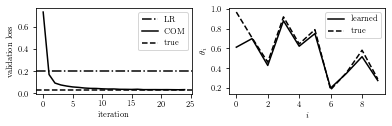

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(5.485, 1.8)

ax[0].axhline(loss_fn(torch.nn.Softmax()(Xval @ theta + theta0) * Xval[:,0][:,None], Yval).item(), linestyle='-.', c='black', label='LR')
ax[0].plot(val_losses, c='black', label='COM')
ax[0].axhline(loss(Xval, Yval, alpha_true).item(), linestyle='--', c='black', label='true')
ax[0].legend()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("validation loss")

ax[1].plot(alpha.detach().numpy(), c='black', label='learned')
ax[1].plot(alpha_true.detach().numpy(), '--', c='black', label='true')
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("$\\theta_i$")
ax[1].legend()

plt.tight_layout()

plt.savefig("figures/resource_allocation.pdf")